# 학습 관련 기술

## 1. 매개변수 갱신

신경망 학습의 목적은 *손실 함수의 값을 가능한 낮추는 **매개변수**를 찾는 것*이다. 이러한 문제를 푸는 것을 **Opimization(최적화)** 이라고 한다.

매개변수의 기울기를 구하고, 기울어진 방향으로 매개변수 값을 갱신하는 일을 반복하는 방법을 **SGD(확률적 경사 하강법)** 이라고 한다.

### 1.1. 확률적 경사 하강법(SGD)

SGD의 수식은 다음과 같다. 

$W = W - \eta\frac{\theta L}{\theta W}$

- **$W$** : 갱신할 가중치 매개변수
- **$\frac{\theta L}{\theta W}$** : W에 대한 손실 함수의 기울기
- **$\eta$** : 학습률(보통 0.01 or 0.001)

SGD를 코드로 구현하면 다음과 같다.

In [3]:
class SGD:
    
    def __init__(self, lr=0.01):
        self.lr = lr # Learning Rate
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

### 1.2. SGD의 단점

$f(x,y) = \frac{1}{20}x^2 + y^2$에 SGD를 적용할 때 효율성이 떨어진다.SGD의 단점은 **비등방성 함수에서 효율성이 떨어지다**는 것이다. 

- **비등방성(anisotropy) 함수** : 방향에 따라 성질(기울기)가 달라지는 함수

### 1.3. 모멘텀

**Momentum(모멘텀)** 은 다음과 같은 수식으로 표현된다.

$v = \alpha v - \eta\frac{\theta L}{\theta W}$

$W = W + v$

- **$v$** : 속도

모멘텀은 다음과 같이 구현된다.

In [4]:
class Momentum:

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]

### 1.4. AdaGrad

학습률을 정하는 방법 중에 **학습률 감소**가 있다. 이는 학습을 진행하면서 학습률을 점차 줄이는 방법이다. **AdaGrad**는 학습률 감소를 이용하여 각각의 매개변수에 대한 적응적(adaprive) 학습률을 설정한다. 수식은 다음과 같이 표현된다.

$h = h + \frac{\theta L}{\theta W} \bullet \frac{\theta L}{\theta W}$ ( $\bullet$ : 행렬 원소별 곱셈)

$W = W - \eta\frac{1}{\sqrt{h}}\frac{\theta L}{\theta W}$

AdaGrad는 다음과 같이 구현된다.

In [5]:
class AdaGrad:

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

### 1.5. Adam

**Adam**은 모멘템과 AdaGrad를 합친 개념이다(http://arxiv.org/abs/1412.6980v8). Adam은 다음과 같이 구현된다. 

In [8]:
class Adam:

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

### 1.6. 최적화 방법 비교

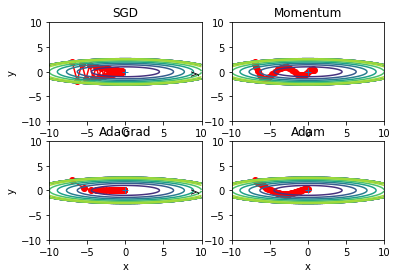

In [15]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

===========iteration:0===========
SGD:2.3817830554788717
Momentum:2.3981001344374873
AdaGrad:1.86738315380398
Adam:2.2013000908592164
===========iteration:500===========
SGD:0.3720016692417724
Momentum:0.1461529854731418
AdaGrad:0.05495000102619179
Adam:0.10246652716478621
===========iteration:1000===========
SGD:0.22486666289401624
Momentum:0.15340264371409992
AdaGrad:0.015983134291998873
Adam:0.04991364841629137
===========iteration:1500===========
SGD:0.2384209129433204
Momentum:0.10920438435216503
AdaGrad:0.043338276679290695
Adam:0.08738755582904364


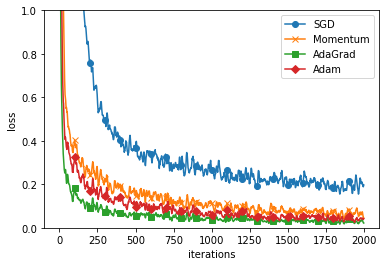

In [18]:
import os
import sys
sys.path.append(os.pardir)
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 500 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

## 2. 가중치 초깃값

가중치의 초깃값 설정은 신경망 학습에 있어서 매우 중요하다. 이를 위한 방법 중 **가중치 감소 기법**이 있다. 이 방법은 오버피팅을 억제해 범용 성능을 높인다.

- **가중치 감소 기법** : 가중치 매개변수의 값이 작아지도록 학습

이렇게 가중치를 감소시키는 이유는 가중치가 작을수록 좋지만 0이 되는 순간 올바른 학습이 이루어지지 않기 때문이다. 가중치가 0이 되면 순전파 떄 더하기 연산만 진행되기 때문에 역전파의 모든 가중치가 똑같이 갱신된다.

### 2.1. 은닉층의 활성화값 분포

가중치에 초깃값에 따라 은닉층의 활성화값의 변화를 살펴보자. 실험을 위한 코드는 다음과 같다.

가중치 표준편차 : 1


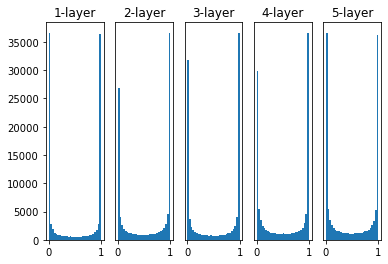

가중치 표준편차 : 0.01


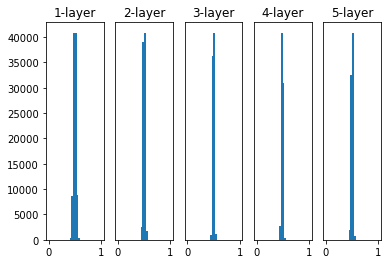

Xavire 초깃값


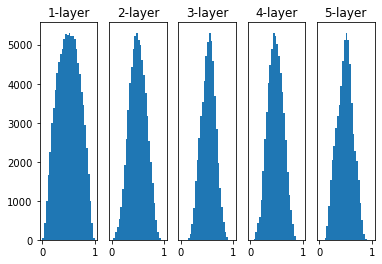

In [8]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations1 = {}  # 이곳에 활성화 결과를 저장
activations2 = {}
activations3 = {}

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w1 = np.random.randn(node_num, node_num) * 1
    w2 = np.random.randn(node_num, node_num) * 0.01
    w3 = np.random.randn(node_num, node_num) / np.sqrt(node_num)

    a1 = np.dot(x, w1)
    a2 = np.dot(x, w2)
    a3 = np.dot(x, w3)

    z1 = sigmoid(a1)
    z2 = sigmoid(a2)
    z3 = sigmoid(a3)

    activations1[i] = z1
    activations2[i] = z2
    activations3[i] = z3
    
# 히스토그램 그리기
print("가중치 표준편차 : 1")
for i, a in activations1.items():
    plt.subplot(1, len(activations1), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

print("가중치 표준편차 : 0.01")
for i, a in activations2.items():
    plt.subplot(1, len(activations2), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

print("Xavire 초깃값")
for i, a in activations3.items():
    plt.subplot(1, len(activations2), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

1. 표준편차가 1인 정규분포를 이용하는 경우, 활성화 값들이 0과 1에 치우쳐있다. 시그모이드 함수는 0or1에 가까워지면 미분 값이 0에 가까워진다. 그렇기 때문에 역전파의 기울기 값이 점점 작아지다가 사라진다. 이를 **기울기 소실**이라고 한다.

2. 표준편차가 0.01인 정규분포를 이용하는 경우, 0.5에 치우쳐있다. 이런 경우 뉴런이 거의 같은 값을 출력하기 때문에 은닉층을 여러개 둔 의미가 없어진다. 이러한 경우를 **표현력의 제한**이 생겼다고 표현한다.

이러한 경우를 방지하기 위해 일반적인 딥러닝 프레임워크에서는 **Xavire 초깃값**을 사용한다. 이는 표준편차가 $\frac{1}{\sqrt{n}}$

### 2.2. ReLU를 사용할 때 가중치 초깃값

ReLU를 사용할 경우 다음과 같은 결과가 나온다.

가중치 표준편차 : 0.01


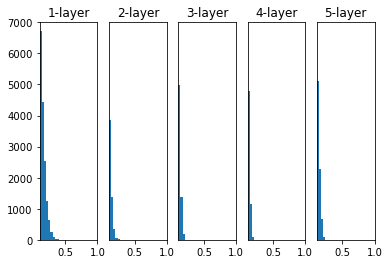

Xavire 초깃값


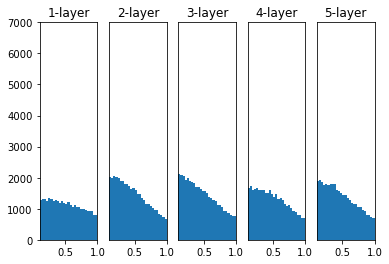

He 초깃값


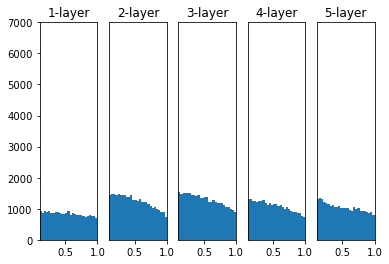

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def ReLU(x):
    return np.maximum(0, x)
    
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations1 = {}  # 이곳에 활성화 결과를 저장
activations2 = {}
activations3 = {}

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w1 = np.random.randn(node_num, node_num) * 0.01
    w2 = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    w3 = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num) 

    a1 = np.dot(x, w1)
    a2 = np.dot(x, w2)
    a3 = np.dot(x, w3)

    z1 = ReLU(a1)
    z2 = ReLU(a2)
    z3 = ReLU(a3)

    activations1[i] = z1
    activations2[i] = z2
    activations3[i] = z3
    
# 히스토그램 그리기
print("가중치 표준편차 : 0.01")
for i, a in activations1.items():
    plt.subplot(1, len(activations1), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

print("Xavire 초깃값")
for i, a in activations2.items():
    plt.subplot(1, len(activations2), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

print("He 초깃값")
for i, a in activations3.items():
    plt.subplot(1, len(activations2), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

**He 초깃값**은 Xavier 초깃값보다 ReLU 함수에 특화된 초깃값이다. 이는 표준편차가 $\sqrt{\frac{2}{n}}$이다.

### 2.3. 가중치 초깃값 비교

===========iteration:0===========
std=0.01:2.302548651693007
Xavier:2.30513114124036
He:2.431068112500792
===========iteration:500===========
std=0.01:2.3031803114494136
Xavier:0.9280113607002843
He:0.3811111930799215
===========iteration:1000===========
std=0.01:2.3002498531610396
Xavier:0.41367836857055484
He:0.28567333786084464
===========iteration:1500===========
std=0.01:2.3034648501294015
Xavier:0.33476260161684257
He:0.22511618715442205


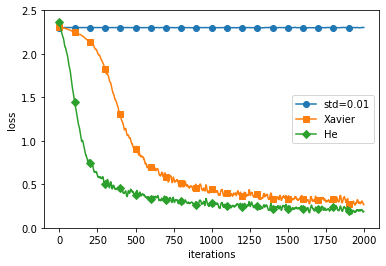

In [17]:
import os
import sys

sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 500 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

끝으로 정리하면 Tech 함수나 Sigmoid 함수와 같이 S자 모양의 함수에서는 Xavier 초깃값이 적합하고, ReLU에서는 He 초깃값이 적당하다.

## 3. 배치 정규화

**Batch Normalization(배치 정규화)** 는 각 층의 활성화를 적당히 퍼트리도록 강제하는 방법으로 다음과 같은 이점이 있다.
1. 학습 속도 개선
2. 초깃값 의존도 하락
3. 오버피팅 억제

배치 정규화를 위해서 `Affine - Batch Norm - ReLU`형태로 신경망을 구성한다. **Batch Norm**은 배치 정규화 계층이다. 

### 3.1. 배치 정규화 효과

C:\Users\1\Deep Learning from Scratch\common\multi_layer_net_extend.py:102: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
C:\Users\1\Deep Learning from Scratch\common\multi_layer_net_extend.py:102: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\1\Deep Learning from Scratch\common\multi_layer_net_extend.py:102: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
C:\Users\1\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\1\Deep Learning from Scratch\common\multi_layer_net_extend.py:102: RuntimeWarning: in

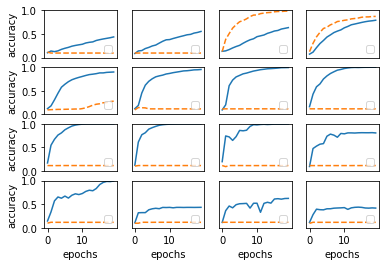

In [26]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(10000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    if i == 15:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

그래프를 보면 대부분의 경우에서 배치 정규화를 사용한 경우의 학습 속도가 빠르다.

## 4. 오버피팅 방지

오버피팅은 다음과 같은 경우에 발생한다.
1. 매개변수가 많고 표현력이 높은 모델
2. 훈련 데이터가 적음

오버피팅이 발생하면 모델이 훈련 데이터에만 적응(fitting)해버리기 때문에 훈련 때 사용하지 않은 시험 데이터에는 제대로 대응하지 못한다.

### 4.1. 가중치 감소

오버피팅은 가중치 매개변수의 값이 커서 발생하는 경우가 많다. 따라서 **Weight decay(가중치 감소)** 를 사용한다. 이는 학습 과정에서 큰 가중치에 그에 상응하는 페널티를 부과하여 오버피팅을 억제한다.

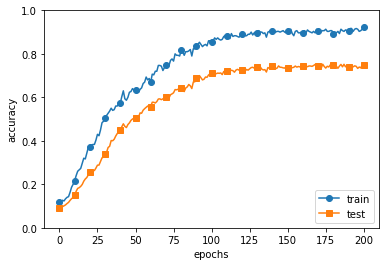

In [28]:
import os
import sys
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

위의 그래프와 같이 훈련 데이터가 100% 적응하지 않았기 때문에 오버피팅이 억제되었다. 

### 4.2. 드롭아웃

**드롭아웃**은 뉴런을 임의로 삭제하면서 학습하는 방법으로 다음과 같이 진행한다.
1. 훈련 : 데이터를 흘릴 때마다 삭제할 뉴런 무작위 선택
2. 시험 : 각 뉴런의 출력에 훈련 떄 삭제한 비율 곱하여 출력
    
이를 구현한 코드는 다음과 같다.

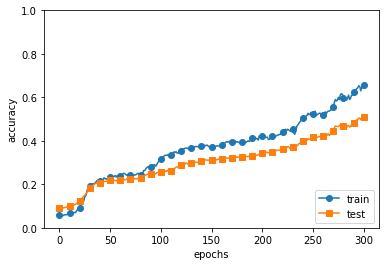

In [40]:
import os
import sys
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=False)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

그래프와 같이 훈련 데이터가 100% 적합하지 않으면서 시험 데이터와의 오차도 줄어들었다.

## 5. 적절한 하이퍼파라미터 값

### 5.1. 검증 데이터

하이퍼파라미터를 조정하기 위해서는 하이퍼파라미터 전용 확인 데이터인 **Validation data(검증 데이터)** 를 사용한다. 

검증 데이터는 훈련 데이터의 20%를 사용한다.

### 5.2. 하이퍼파라미터 최적화

하이퍼파라미터 최적화는 다음과 같은 과정으로 수행된다. 

0. 하이퍼파라미터 값의 범위 설정
1. 설정된 범위에서 하이퍼파라미터 값 무작위 추출
2. 1단계에서 추출된 값으로 학습 후 검증데이터로 평가
3. 1,2 단계 반복 후 하이퍼파라미터의 범위 축소

하이퍼파라미터 최적화의 경우 다음과 같은 선행 연구 결과가 있다.

1. 하이퍼파리미터 범위는 10의 거듭제곱 단위로 지정
2. 에폭을 작게 설정

베이즈 정리를 바탕으로한 **베이즈 최적화**방식으로 효율적으로 최적화를 진행할 수도 있다.

=========== Hyper-Parameter Optimization Result ===========
Best-1(val acc:0.83) | lr:0.008621970006512492, weight decay:1.0410822479746748e-06
Best-2(val acc:0.8) | lr:0.008847039597630335, weight decay:2.808164785652649e-07
Best-3(val acc:0.76) | lr:0.007328619455460868, weight decay:1.3888767642544129e-08
Best-4(val acc:0.7) | lr:0.005531509263376869, weight decay:3.9316267525169674e-08
Best-5(val acc:0.66) | lr:0.007426644021912375, weight decay:3.1592062120781045e-05
Best-6(val acc:0.66) | lr:0.004683605180839981, weight decay:1.787195600232528e-05
Best-7(val acc:0.57) | lr:0.0033065823775739567, weight decay:2.72715411667451e-07
Best-8(val acc:0.47) | lr:0.002476464736216846, weight decay:2.768226807883413e-08
Best-9(val acc:0.41) | lr:0.00340773753991698, weight decay:3.93223540234521e-06
Best-10(val acc:0.41) | lr:0.0019524656613008659, weight decay:8.997548076080172e-08
Best-11(val acc:0.37) | lr:0.002767405196316599, weight decay:1.6308488097889185e-08
Best-12(val acc:0.37) |

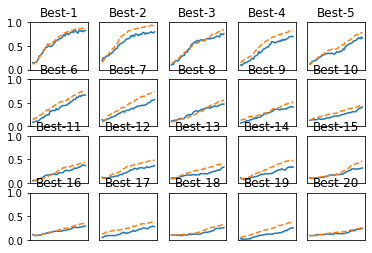

In [47]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

위 그래프는 검증 데이터의 학습 추이를 정확도가 높은 순서로 나열한 것이다. 코드에서 설정한 범위는 다음과 같다. 

- **lr** : $10^{-6}$ ~ $10^{-2}$
- **weight decay** : $10^{-8}$ ~ $10^{-4}$

위 코드 결과에서 가장 학습이 잘된 5개를 살펴보면 다음과 같이 정리된다.

- **lr** : $10^{-3}$ ~ $10^{-2}$
- **weight decay** : $10^{-8}$ ~ $10^{-6}$

이렇게 축소된 범위로 변경하여 해당 코드를 반복해서 진행한다면 보다 적절한 값의 하이퍼파라미터 값을 얻을 수 있다.